<h1><center>Boundary Data Immersion Method (BDIM)</center></h1>

---

<h3>Marin Lauber 2020</h3>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import NSsolver as ns
from scipy import optimize, linalg
try:
    plt.style.use("jupyter")
except OSError:
    print("Delaut syle in use")

The idea of the Boudnary Data Immersion method is to analytically combine the field equation of the body and the fluid analytically, through a convolution. This results in the \emph{Meta}-equation, valid ofver the full domain

\begin{equation}
    \vec{u}_\varepsilon = \mu_0 \vec{f} + (1-\mu_0)\vec{b} + \mu_1\frac{\partial}{\partial n}(\vec{f}-\vec{b})
\end{equation}

where $\mu_0$ and $\mu_1$ are the zeroth- and first- kernel moments defined as

\begin{equation}
\mu_n = \int_{\Omega_{f}} (x-x_b)^n\phi(x-x_f, \varepsilon) \text{ d}x_f,
\end{equation}

where the convolution kernel is

\begin{equation}
\phi(d, \varepsilon) = \frac{1}{2\varepsilon}\left(1+\cos\left(\frac{d}{\varepsilon}\pi\right)\right)
\end{equation}

which means that the zeroth and first moments are, respectively

\begin{split}
\mu_0 & = \frac{1}{2}\left(1 + \frac{d}{\varepsilon} + \frac{1}{pi}\sin\left(\frac{d}{\varepsilon}\pi\right)\right)\\
\mu_1 & = \varepsilon\left(\frac{1}{4}- \left(\frac{d}{2\varepsilon}\right)^2  - \frac{1}{2\pi} \left[\frac{d}{\varepsilon}\sin\left(\frac{d}{\varepsilon}\pi\right) + \frac{1}{\pi}\left[1+\cos\left(\frac{d}{\varepsilon}\pi\right)\right]\right]\right)
\end{split}


In [3]:
def kernel(d, e):
    return np.where(abs(d)<e, 0.5*(1+np.cos(d/e*np.pi)), 0)

def mu_0(d, e):
    return np.where(d<=-e, 0, np.where(abs(d)<e, 0.5*(1 + d/e + 1./np.pi*np.sin(d*np.pi/e)), 1.))
    
def mu_1(d, e):
    return np.where(abs(d)<e, e*(0.25 - (d/(2*e))**2 - 1./(2*np.pi)*((d/e)*np.sin(d*np.pi/e) +\
                                                                   (1./np.pi)*(1+np.cos(d*np.pi/e)))), 0)

The zeroth-kernel moment must be zero inside the body ($x/\varepsilon\le-1$), and 1 in the fluid ($x/\varepsilon\ge1$). Smothing occurs over a width of $2\varepsilon$ and inhthis tansition zone, the zeroth-moment gradually ramps from 0 to 1

In [4]:
assert mu_0(-1, 1)==0
assert mu_0( 0, 1)==0.5
assert mu_0( 1, 1)==1

The first kernel-moment must also vanish at the edge of moothing regionaq

In [5]:
assert mu_1( 1, 1)==0
assert mu_1(-1, 1)==0

We can now define our simple 1D piston body. This is defined with a given thickness $t$ and is located at $X$

In [6]:
def Body(x, X, t=10, e=2):
    # distance normalised by grid size
    d = abs((X - x)/(x[1]-x[0])) - t/2
    return d, mu_0(d, e), mu_1(d, e)

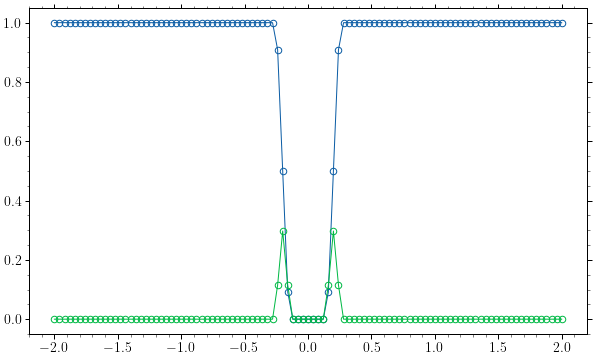

In [7]:
x, dx = np.linspace(-2, 2, 101, retstep=True)
d, mu0, mu1 = Body(x, 0, 10, 2)
plt.plot(x, mu0, "-o", x, mu1, "-o");

By changing $t$ we can ealisy change the thickness of our piston

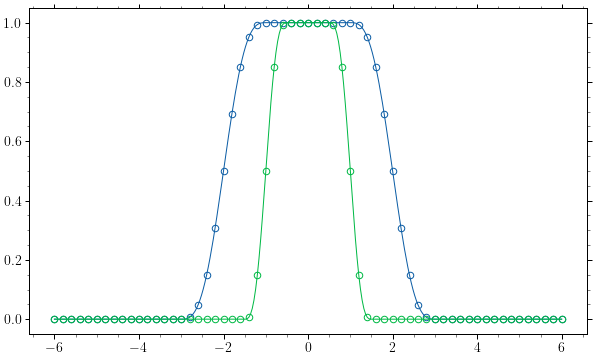

In [8]:
x = np.linspace(-6, 6, 301)
for t, eps in zip([4, 2],[1.,0.5]):
    d  = abs(x)-t/2.
    plt.plot(x, 1.-mu_0(d, eps), '-o', markevery=5);

## Projection Method

To solve the coupled momentum and continuity equation, we use Chorin's [projection method](https://en.wikipedia.org/wiki/Projection_method_(fluid_dynamics)). The intermediate velocity field is obtaned by explicitely adding viscous and convective contributions, as well as the influence of the body

$$
       u^* = \mu_0\left(u^n + r_{\Delta t}(u^n)\right) + (1-\mu_0)V_p + \mu_1\frac{\partial}{\partial n}\left(u^n + r_{\Delta t}(u^n) - V_b\right),
$$

to enforce the divergence-free constraint on this intermediate velocity field, we compute a pressure field that ensures that $\nabla\cdot u^{n+1}=0$ by solving the elliptical equation

$$
    \Delta t\nabla\cdot\left(\frac{\mu_0}{\rho}\nabla p^0\right) = \nabla\cdot u^*.
$$

The final velocity field is obtained by adding the resulting pressure field to the intermediate velocity field

$$
    u^{n+1} = u^* + \frac{\Delta t}{\rho}\mu_0\nabla p^0.
$$

In [9]:
def update(x, u, V, X, dx, dt, t):
    
    # get body position
    d, mu0, mu1 = Body(x, X, t, e=2)
    
    # predict velocity 
    u_star = mu0*(u + dt*ns.r(u, dx)) + (1-mu0)*V + mu1*ns.ddn(u + dt*ns.r(u, dx) - V, dx)
    
    # get pressure
    sigma = ns.div(u_star, dx)
    p = ns.solve_pressure(mu0, sigma, dx)
    
    # correct
    u_n = u_star - dt*mu0*ns.grad(p, dx)
    
    return d, mu0, mu1, u_star, sigma, p, u_n

We can wo test the method with our piston problem, We start with a thickness $t=10$ and 64 grid points

In [10]:
N = 64
x, dx = np.linspace(-1, 1, N, retstep=True)
xs = x + 0.5*dx # scalar cell-centred values
X = 0.0 #np.random.rand()-0.5
V = 1
u0 = np.zeros_like(x)
dt = 1.

d, mu, mu1, us, sigma, p, u_n = update(x, u0, V, X, dx, dt, 10)
print("Interface at X: %.2f" % X)
print(r"L inf %.3e" % np.max(np.abs(u_n -  V)))

Interface at X: 0.00
L inf 2.804e-10


The results match the analytical solution very well, we can draw the piston case to see what each of the contribution are

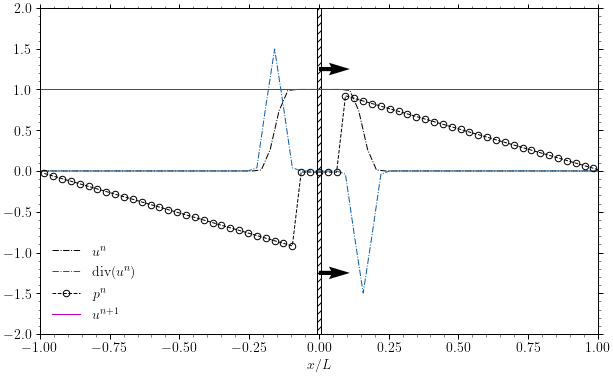

In [11]:
ns.draw_results(x, xs, X, us, u_n, p, sigma/10, V=1, fname='None')